In [3]:
import cv2
from tqdm import tqdm
import shutil
from random import sample
import numpy as np
import math
from utilis import *
from yolo_to_voc2 import export_yolo_to_voc_2

MAIN_PATH = os.path.join('Tensorflow', 'workspace', 'images')
VIDEOS_PATH = create_path(os.path.join(MAIN_PATH, '1_videos'))
IMAGES_PATH = create_path(os.path.join(MAIN_PATH, '2_images'))
FILTERED_PATH = create_path(os.path.join(MAIN_PATH, '3_filtered'))
FILTERED_TRUE_PATH = create_path(os.path.join(FILTERED_PATH, 'true'))
FILTERED_FALSE_PATH = create_path(os.path.join(FILTERED_PATH, 'false'))
YOLO_IMAGES_PATH = create_path(os.path.join(MAIN_PATH, '4_YOLO_images'))
VOC2_IMAGES_PATH = create_path(os.path.join(MAIN_PATH, '5_VOC2_images'))

### 1. Make frames from video

In [37]:
IMAGE_WIDTH = 640
DESIRED_FRAMERATE_MS = 640


def calculate_skip_frames(video_fps, desired_framerate_ms):
    skip_frames = video_fps / (1000 / desired_framerate_ms)
    return math.ceil(skip_frames)

In [16]:
for file_index, filename in VIDEOS_DICT.items():
    vidcap = cv2.VideoCapture(os.path.join(VIDEOS_PATH, filename))
    video_fps = vidcap.get(cv2.CAP_PROP_FPS)
    count = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames = calculate_skip_frames(video_fps, DESIRED_FRAMERATE_MS)
    for frame_index in tqdm(range(count)[::skip_frames]):
        vidcap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
        success, img = vidcap.read()
        if img.shape[2] == 3:
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        crop_img = img[20:600, 0:800]
        resize = cv2.resize(crop_img, (IMAGE_WIDTH, IMAGE_WIDTH))
        cv2.imwrite(os.path.join(os.path.join(IMAGES_PATH), f"{file_index}_{frame_index}.png"), resize)

 22%|██▏       | 562/2600 [00:13<00:49, 41.40it/s]


KeyboardInterrupt: 

### 2. Filter frames

In [5]:
true_files = []
false_files = []

for file in tqdm(os.listdir(IMAGES_PATH), "filtering"):
    image = cv2.imread(os.path.join(IMAGES_PATH, file))
    suma = np.count_nonzero(image > 200)
    if suma > 10:
        # cv2.putText(image, str(suma), (0, 240), cv2.FONT_HERSHEY_SIMPLEX, 1, 255)
        # cv2.imshow('img', image)
        # cv2.waitKey(100)
        true_files.append(file)
    false_files.append(file)
false_files_small = sample(false_files, len(true_files))

filtering: 100%|██████████| 57371/57371 [06:10<00:00, 155.00it/s]


In [6]:
for file in tqdm(true_files, "saving true"):
    shutil.copy2(os.path.join(IMAGES_PATH, file), os.path.join(FILTERED_TRUE_PATH, file))
for file in tqdm(false_files_small, "saving false"):
    shutil.copy2(os.path.join(IMAGES_PATH, file), os.path.join(FILTERED_FALSE_PATH, file))

saving false: 100%|██████████| 18253/18253 [00:28<00:00, 631.23it/s]


### 3. Labelling images

In [1]:
# command = f"labelImg {paths['TRAIN_PATH']}"
command = f"labelImg Tensorflow/workspace/images/3_filtered/true"
print(command)

labelImg Tensorflow/workspace/images/3_filtered/true


### 4. Statistics about set

In [23]:
all_true_files = os.listdir(FILTERED_TRUE_PATH)
all_true_files_set = {os.path.splitext(x)[0] for x in all_true_files}
all_true_files_set.remove('classes')
# all_true_files_set.remove('.tmp')

classes_per_video_count = {x: 0 for x in VIDEOS_DICT}
classes_count = {'front': 0, 'rear': 0, 'undefined_class': 0}

for x in all_true_files_set:
    img = x + '.png'
    annotation = x + '.txt'
    video_id = int(x[0:2].replace('_', ''))

    if not os.path.isfile(os.path.join(FILTERED_TRUE_PATH, annotation)):
        continue
    with open(os.path.join(FILTERED_TRUE_PATH, annotation), 'r') as f:
        lines = f.read().splitlines()
        if not lines:
            continue
        for y in lines:
            class_number = int(y[0])
            if class_number == 1:
                classes_count['front'] += 1
            elif class_number == 0:
                classes_count['rear'] += 1
            else:
                classes_count['undefined_class'] += 1

            classes_per_video_count[video_id] += 1

print('Classes per video count:', classes_per_video_count)
print('Count per class:', classes_count)
print('Total classified classes:', classes_count['front'] + classes_count['rear'])

Classes per video count: {0: 484, 1: 107, 2: 77, 3: 236, 4: 56, 5: 160, 6: 64, 7: 81, 8: 95, 9: 40, 10: 49, 11: 35, 12: 41, 13: 236, 14: 42, 15: 200}
Count per class: {'front': 1003, 'rear': 1000, 'undefined_class': 0}
Total classified classes: 2003


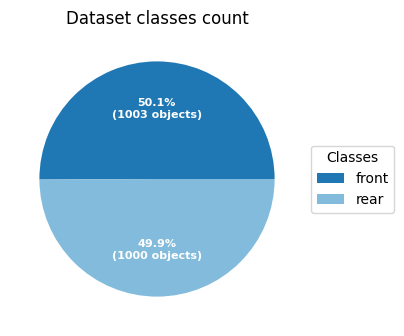

In [45]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))

recipe = ["front", "rear"]

data = [classes_count['front'], classes_count['rear']]
ingredients = [x.split()[-1] for x in recipe]


def func(pct, allvals):
    absolute = int(np.round(pct / 100. * np.sum(allvals)))
    return "{:.1f}%\n({:d} objects)".format(pct, absolute)


wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"))

ax.legend(wedges, ingredients,
          title="Classes",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=8, weight="bold")

ax.set_title("Dataset classes count")

plt.show()


### Export classified images

In [25]:
all_true_files = os.listdir(FILTERED_TRUE_PATH)
shutil.copy2(os.path.join(FILTERED_TRUE_PATH, 'classes.txt'), os.path.join(YOLO_IMAGES_PATH, 'classes.txt'))
for x in tqdm(all_true_files_set, "saving Yolo classes"):
    img = x + '.png'
    annotation = x + '.txt'

    if not os.path.isfile(os.path.join(FILTERED_TRUE_PATH, annotation)):
        continue
    with open(os.path.join(FILTERED_TRUE_PATH, annotation), 'r') as f:
        lines = f.read().splitlines()
        if not lines:
            continue
    shutil.copy2(os.path.join(FILTERED_TRUE_PATH, img), os.path.join(YOLO_IMAGES_PATH, img))
    shutil.copy2(os.path.join(FILTERED_TRUE_PATH, annotation), os.path.join(YOLO_IMAGES_PATH, annotation))

saving Yolo classes: 100%|██████████| 18253/18253 [00:03<00:00, 5999.98it/s]


### Export YOLO to VOC2

YOLO to VOC2: 100%|██████████| 3235/3235 [00:15<00:00, 213.92it/s]


### Statistics about test dataset

In [63]:
test_path = os.path.join(MAIN_PATH, 'yolo', 'test')
all_true_files = os.listdir(test_path)
all_true_files_set = {os.path.splitext(x)[0] for x in all_true_files}
all_true_files_set.remove('classes')
# all_true_files_set.remove('.tmp')

classes_per_video_count = {x: 0 for x in VIDEOS_DICT}
classes_count = {'front': 0, 'rear': 0, 'undefined_class': 0}

for x in all_true_files_set:
    img = x + '.png'
    annotation = x + '.txt'
    video_id = int(x[0:2].replace('_', ''))

    if not os.path.isfile(os.path.join(test_path, annotation)):
        continue
    with open(os.path.join(test_path, annotation), 'r') as f:
        lines = f.read().splitlines()
        if not lines:
            continue
        for y in lines:
            class_number = int(y[0])
            if class_number == 1:
                classes_count['front'] += 1
            elif class_number == 0:
                classes_count['rear'] += 1
            else:
                classes_count['undefined_class'] += 1

            classes_per_video_count[video_id] += 1

print('Classes per video count:', classes_per_video_count)
print('Count per class:', classes_count)
print('Total classified classes:', classes_count['front'] + classes_count['rear'])

Classes per video count: {0: 8, 1: 11, 2: 28, 3: 40, 4: 22, 5: 24, 6: 22, 7: 17, 8: 35, 9: 17, 10: 9, 11: 11, 12: 10, 13: 85, 14: 9, 15: 52}
Count per class: {'front': 189, 'rear': 211, 'undefined_class': 0}
Total classified classes: 400


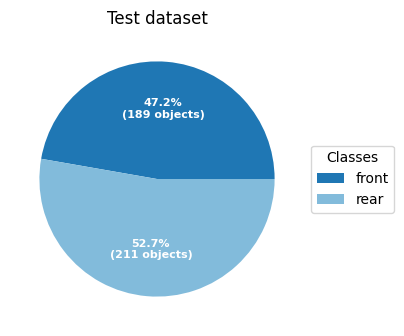

In [64]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))

recipe = ["front", "rear"]

data = [classes_count['front'], classes_count['rear']]
ingredients = [x.split()[-1] for x in recipe]


def func(pct, allvals):
    absolute = int(np.round(pct / 100. * np.sum(allvals)))
    return "{:.1f}%\n({:d} objects)".format(pct, absolute)


wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"))

ax.legend(wedges, ingredients,
          title="Classes",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=8, weight="bold")

ax.set_title("Test dataset")

plt.show()

In [65]:
train_path = os.path.join(MAIN_PATH, 'yolo', 'train')
all_true_files = os.listdir(train_path)
all_true_files_set = {os.path.splitext(x)[0] for x in all_true_files}
all_true_files_set.remove('classes')
# all_true_files_set.remove('.tmp')

classes_per_video_count = {x: 0 for x in VIDEOS_DICT}
classes_count = {'front': 0, 'rear': 0, 'undefined_class': 0}

for x in all_true_files_set:
    img = x + '.png'
    annotation = x + '.txt'
    video_id = int(x[0:2].replace('_', ''))

    if not os.path.isfile(os.path.join(train_path, annotation)):
        continue
    with open(os.path.join(train_path, annotation), 'r') as f:
        lines = f.read().splitlines()
        if not lines:
            continue
        for y in lines:
            class_number = int(y[0])
            if class_number == 1:
                classes_count['front'] += 1
            elif class_number == 0:
                classes_count['rear'] += 1
            else:
                classes_count['undefined_class'] += 1

            classes_per_video_count[video_id] += 1

print('Classes per video count:', classes_per_video_count)
print('Count per class:', classes_count)
print('Total classified classes:', classes_count['front'] + classes_count['rear'])

Classes per video count: {0: 476, 1: 96, 2: 49, 3: 196, 4: 34, 5: 136, 6: 42, 7: 64, 8: 60, 9: 23, 10: 40, 11: 24, 12: 31, 13: 151, 14: 33, 15: 148}
Count per class: {'front': 814, 'rear': 789, 'undefined_class': 0}
Total classified classes: 1603


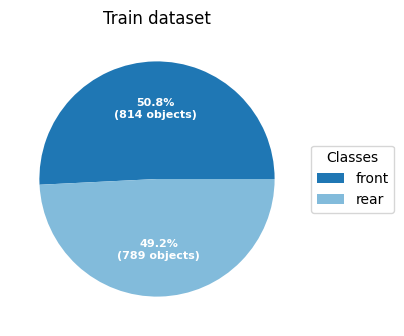

In [66]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))

recipe = ["front", "rear"]

data = [classes_count['front'], classes_count['rear']]
ingredients = [x.split()[-1] for x in recipe]


def func(pct, allvals):
    absolute = int(np.round(pct / 100. * np.sum(allvals)))
    return "{:.1f}%\n({:d} objects)".format(pct, absolute)


wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"))

ax.legend(wedges, ingredients,
          title="Classes",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=8, weight="bold")

ax.set_title("Train dataset")

plt.show()

In [67]:
export_yolo_to_voc_2(os.path.join(MAIN_PATH, 'voc_2', 'train'), train_path)
export_yolo_to_voc_2(os.path.join(MAIN_PATH, 'voc_2', 'test'), test_path)

YOLO to VOC2: 100%|██████████| 591/591 [00:01<00:00, 403.78it/s]
